<a href="https://colab.research.google.com/github/Cafta/PUC/blob/Gabriela/ML_IoT/Projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PARTE 1: Importando os Dados
Importar dados do site http://extrasensory.ucsd.edu/intro2extrasensory/intro2extrasensory.html, mais especificamente o dataset "Primary data - features and labels"

In [22]:
import requests
import zipfile
import os #funcionalidades dependentes do sistema operacional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob #manipulação de arquivos e diretórios
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import math

In [23]:
#Pegar a url do arquivo zip
url = 'http://extrasensory.ucsd.edu/data/primary_data_files/ExtraSensory.per_uuid_features_labels.zip'

#Definir o caminho local para salvar o aquivo e depois extrair os dados
zip_path = '/content/EXTRASENSORY_features_labels.zip'
extract_path = '/content/EXTRASENSORY_features_labels/'

#Baixar o arquivo zip
response = requests.get(url)
with open(zip_path, 'wb') as file: #with garante que o arquivo será corretamente fechado após a operação
  file.write(response.content) #escreve o conteúdo do arquivo baixado no arquivo aberto

#Descompactar o aquivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)


## PARTE 1.1: Criando o DataFrame do Pandas

Gerar o dataframe e poder visualizar os dados.
Lembrar que são dados para vários usuários, por isso teremos que criar uma lista de identificador para cada usuário

In [24]:
#caminho para os arquivos CSV descompactados
csv_files = glob.glob(os.path.join(extract_path, '*.csv.gz')) #os.path.join concatena. Fica assim: /<extract_path>/*.csv.gz
    # * representa qualquer sequência de caracteres
    #glob.glob retorna uma lista de todos os caminhos de arquivos no diretório extract_path que correspondem ao padrão definido (*.csv.gz)

#Lista para armazenar Dataframes de cada usuário
df_lista = []

#Para iterar arquivos  CSV e carregar cada um em um df
for file in csv_files:
  user_id = os.path.basename(file).split('.')[0] #extrai o número ID dos usuários
  df = pd.read_csv(file, compression= 'gzip')
  df['user_id'] = user_id #vai adicionar uma coluna com o identificador
  df_lista.append(df)

# Transforma uma lista para um dataframe do pandas:
df_final = pd.concat(df_lista, ignore_index=True)
print(f'Tipo de df_lista: {type(df_lista)},\ntipo de df_final: {type(df_final)}\n')

# Entendendo o data frame construido:
df_final.info()

Tipo de df_lista: <class 'list'>,
tipo de df_final: <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377346 entries, 0 to 377345
Columns: 279 entries, timestamp to user_id
dtypes: float64(276), int64(2), object(1)
memory usage: 803.2+ MB


# PARTE 2: Reconhecimento dos dados



In [25]:
# Vemos que tem 279 colunas (aff! é difícil de avaliar assim...)
# São 276 colunas de float64, 2 int64 e 1 de objeto.
# São 377345 linhas;

# Vamos criar uma listagem com o nome das colunas e o seu tipo de dados para tentar entender melhor os dados:
data_types = df_final.dtypes.to_dict()
column_names = list(df_final.columns)
data_types_list = []

for i in range(len(column_names)):
  data_types_list.append([column_names[i], data_types[column_names[i]]])

for coluna in data_types_list:
  print(f'{coluna[0]}({coluna[1]})')


timestamp(int64)
raw_acc:magnitude_stats:mean(float64)
raw_acc:magnitude_stats:std(float64)
raw_acc:magnitude_stats:moment3(float64)
raw_acc:magnitude_stats:moment4(float64)
raw_acc:magnitude_stats:percentile25(float64)
raw_acc:magnitude_stats:percentile50(float64)
raw_acc:magnitude_stats:percentile75(float64)
raw_acc:magnitude_stats:value_entropy(float64)
raw_acc:magnitude_stats:time_entropy(float64)
raw_acc:magnitude_spectrum:log_energy_band0(float64)
raw_acc:magnitude_spectrum:log_energy_band1(float64)
raw_acc:magnitude_spectrum:log_energy_band2(float64)
raw_acc:magnitude_spectrum:log_energy_band3(float64)
raw_acc:magnitude_spectrum:log_energy_band4(float64)
raw_acc:magnitude_spectrum:spectral_entropy(float64)
raw_acc:magnitude_autocorrelation:period(float64)
raw_acc:magnitude_autocorrelation:normalized_ac(float64)
raw_acc:3d:mean_x(float64)
raw_acc:3d:mean_y(float64)
raw_acc:3d:mean_z(float64)
raw_acc:3d:std_x(float64)
raw_acc:3d:std_y(float64)
raw_acc:3d:std_z(float64)
raw_acc:3d:

In [26]:
# Parece que tem um padrão de ':', vamos tentar agrupar um pouco mais (só para melhor avaliação):
# Pois fica mais fácil avaliar com 71 categorias ao invés de 279.
lista_resumida_colunas = []
for coluna in data_types_list:
  if ':' in coluna[0]:
    nome_dividido = coluna[0].split(':')
    if len(nome_dividido) == 1:
      lista_resumida_colunas.append(nome_dividido[0])
    elif len(nome_dividido) >= 2:
      if nome_dividido[0] == 'discrete'or nome_dividido[0] == 'label':
        if f'{nome_dividido[0]}:{nome_dividido[1]}' not in lista_resumida_colunas:
          lista_resumida_colunas.append(f'{nome_dividido[0]}:{nome_dividido[1]}')
      else:
        if nome_dividido[0] not in lista_resumida_colunas:
          lista_resumida_colunas.append(nome_dividido[0])
  else:
    lista_resumida_colunas.append(coluna[0])
for coluna in lista_resumida_colunas:
  print(coluna)


timestamp
raw_acc
proc_gyro
raw_magnet
watch_acceleration
watch_heading
location
location_quick_features
audio_naive
audio_properties
discrete:app_state
discrete:battery_plugged
discrete:battery_state
discrete:on_the_phone
discrete:ringer_mode
discrete:wifi_status
lf_measurements
discrete:time_of_day
label:LYING_DOWN
label:SITTING
label:FIX_walking
label:FIX_running
label:BICYCLING
label:SLEEPING
label:LAB_WORK
label:IN_CLASS
label:IN_A_MEETING
label:LOC_main_workplace
label:OR_indoors
label:OR_outside
label:IN_A_CAR
label:ON_A_BUS
label:DRIVE_-_I_M_THE_DRIVER
label:DRIVE_-_I_M_A_PASSENGER
label:LOC_home
label:FIX_restaurant
label:PHONE_IN_POCKET
label:OR_exercise
label:COOKING
label:SHOPPING
label:STROLLING
label:DRINKING__ALCOHOL_
label:BATHING_-_SHOWER
label:CLEANING
label:DOING_LAUNDRY
label:WASHING_DISHES
label:WATCHING_TV
label:SURFING_THE_INTERNET
label:AT_A_PARTY
label:AT_A_BAR
label:LOC_beach
label:SINGING
label:TALKING
label:COMPUTER_WORK
label:EATING
label:TOILET
label:GROOM

In [27]:
len(lista_resumida_colunas)

71

In [28]:
# Vamos descobrir quantos usuários existem neste banco de dados:
users_ids = df_final['user_id'].unique()
print(f"Número de Usuários: {len(users_ids)}")
print("\nAgora já podemos acessar a lista de usuários na lista: users_ids.")

Número de Usuários: 60

Agora já podemos acessar a lista de usuários na lista: users_ids.


In [29]:
# Vamos fazer uma avaliação geral sobre as medições de cada um dos voluntários.
import datetime

timestamps = {}
n_medicoes = {}

for user_id in users_ids:
  user_timestamps = df_final[df_final['user_id'] == user_id]['timestamp']
  timestamps[user_id] = {
      'min': datetime.datetime.fromtimestamp(user_timestamps.min()).strftime('%d/%m/%Y, %H:%M:%S'),
      'max': datetime.datetime.fromtimestamp(user_timestamps.max()).strftime('%d/%m/%Y, %H:%M:%S'),
      'dias': (datetime.datetime.fromtimestamp(user_timestamps.max()) - datetime.datetime.fromtimestamp(user_timestamps.min())).days
  }
  n_medicoes[user_id] = len(df_final[df_final['user_id'] == user_id])

i=0
for user_id, timestamp_info in timestamps.items():
  print(f"({i})\tUser_ID: {user_id}  Adesão: {timestamp_info['min']}" \
        f"  Final: {timestamp_info['max']}  total_dias: {timestamp_info['dias']}" \
        f"  número_de_medições: {n_medicoes[user_id]}  Densidade: {int(n_medicoes[user_id]/timestamp_info['dias'])}")
  i+=1


(0)	User_ID: 99B204C0-DD5C-4BB7-83E8-A37281B8D769  Adesão: 08/10/2015, 21:25:47  Final: 16/10/2015, 16:06:56  total_dias: 7  número_de_medições: 6038  Densidade: 862
(1)	User_ID: 24E40C4C-A349-4F9F-93AB-01D00FB994AF  Adesão: 21/10/2015, 18:28:52  Final: 02/11/2015, 05:10:27  total_dias: 11  número_de_medições: 4771  Densidade: 433
(2)	User_ID: 27E04243-B138-4F40-A164-F40B60165CF3  Adesão: 23/11/2015, 22:11:26  Final: 01/12/2015, 19:08:41  total_dias: 7  número_de_medições: 4927  Densidade: 703
(3)	User_ID: 78A91A4E-4A51-4065-BDA7-94755F0BB3BB  Adesão: 01/12/2015, 22:30:40  Final: 11/12/2015, 04:49:44  total_dias: 9  número_de_medições: 11996  Densidade: 1332
(4)	User_ID: 11B5EC4D-4133-4289-B475-4E737182A406  Adesão: 19/08/2015, 16:07:35  Final: 26/08/2015, 18:09:31  total_dias: 7  número_de_medições: 8845  Densidade: 1263
(5)	User_ID: 4E98F91F-4654-42EF-B908-A3389443F2E7  Adesão: 05/11/2015, 19:10:38  Final: 12/11/2015, 19:05:57  total_dias: 6  número_de_medições: 3250  Densidade: 541


In [30]:
# Primeiras 5 linhas de df_final apenas com as colunas cujo nome começa com 'lables:

filtered_df = df_final.filter(like='label:')
filtered_df.head()


,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,1.0,0.0,...,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0
1,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,1.0,0.0,...,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0
2,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,1.0,0.0,...,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0
3,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,1.0,0.0,...,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0
4,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,1.0,0.0,...,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0


In [31]:
# Verificando a relação entre o tempo e a amostragem de uma variável
user_id = users_ids[3]
df_user = df_final[df_final['user_id'] == user_id]
filtered_df = df_user[['timestamp', 'location:num_valid_updates', 'label:EATING', 'label:OR_standing']].sort_values('timestamp')
for i in range(200, 300):
  print(f'timestamp: {filtered_df.iloc[i, 0]}  location(num_valid_updates): {filtered_df.iloc[i, 1]}, Eating: {filtered_df.iloc[i, 2]}, standing: {filtered_df.iloc[i, 3]}')

timestamp: 1449021034  location(num_valid_updates): 11.0, Eating: nan, standing: 1.0
timestamp: 1449021094  location(num_valid_updates): 9.0, Eating: nan, standing: 1.0
timestamp: 1449021154  location(num_valid_updates): 10.0, Eating: nan, standing: 1.0
timestamp: 1449021214  location(num_valid_updates): 6.0, Eating: nan, standing: 1.0
timestamp: 1449021274  location(num_valid_updates): 7.0, Eating: nan, standing: 1.0
timestamp: 1449021334  location(num_valid_updates): 7.0, Eating: nan, standing: 1.0
timestamp: 1449021394  location(num_valid_updates): 7.0, Eating: nan, standing: 1.0
timestamp: 1449021454  location(num_valid_updates): 15.0, Eating: nan, standing: 1.0
timestamp: 1449021514  location(num_valid_updates): 29.0, Eating: nan, standing: 1.0
timestamp: 1449021574  location(num_valid_updates): 35.0, Eating: nan, standing: nan
timestamp: 1449021634  location(num_valid_updates): 26.0, Eating: nan, standing: nan
timestamp: 1449021694  location(num_valid_updates): 27.0, Eating: nan,

In [32]:
# Avaliando a quantidade de valores cofirmados de comendo e não comendo
user = 3
df_user = df_final #[df_final['user_id'] == users_ids[user]]
filtered_eating = df_user[df_user['label:EATING'] == 1]
filtered_not_eating = df_user[df_user['label:EATING'] == 0]
print(f'Eating: {len(filtered_eating)}, not eating: {len(filtered_not_eating)}')

Eating: 16594, not eating: 279887


Penso que a gente deveria cortar todos os que não está definido se está comendo ou não. Explico: Queremos que nossa rede neural acerte se a pessoa está comendo ou não, e não temos nenhum interesse em que a rede acerte se esta informação foi coletada ou não. Essa informação não nos interessa. Então vamos tirar ela do treinamento. Ainda assim podemos colocar os dados que não se sabe se está comendo ou não, que nossa rede "teoricamente" deveria reconhecer se está ou não comendo mesmo que esta informação não tenha sido fornecida.

In [33]:
# Normalizar os dados
weights_comendo = np.ones(len(filtered_eating)) / len(filtered_eating)
weights_nao_comendo = np.ones(len(filtered_not_eating)) / len(filtered_not_eating)

In [34]:
# Fazendo uma comparação para as variáveis analizadas - UM ÚNICO GRÁFICO:
def compara_unico(coluna_numero, bins=30, min=-1, max=-1):
  if (min==max):
    min = df_user[colunas[coluna_numero]].min()
    max = df_user[colunas[coluna_numero]].max()
  # Definir os intervalos (bins)
  bins = np.linspace(min, max, bins)

  # Plotar os histogramas
  plt.hist(filtered_eating[colunas[coluna_numero]], bins=bins,
           weights=weights_comendo, alpha=0.5, label='Comendo', color='blue')
  plt.hist(filtered_not_eating[colunas[coluna_numero]], bins=bins,
           weights=weights_nao_comendo, alpha=0.5, label='Não Comendo', color='red')

  # Adicionar rótulos e título
  plt.xlabel(f'{colunas[coluna_numero]}')
  plt.ylabel('Frequência Normalizada')
  plt.title(f'Variável: {colunas[coluna_numero]}')
  plt.legend(loc='upper right')

  # Mostrar o gráfico
  plt.show()


In [35]:
# Fazendo uma comparação para as variáveis analizadas MULTIPLOS GRÁFICOS SEQUENCIAIS:
def compara(coluna_numero, n_graficos=3, bins=30, matrix_min_max=[]):
  if (n_graficos > 2):
    n_linhas = math.ceil(n_graficos/3)
  else:
    n_linhas = 1
  fig, axs = plt.subplots(nrows=n_linhas, ncols=3, figsize=(20, 5 * n_linhas))
  axs = axs.flatten() if n_graficos > 1 else [axs]

  for i in range(n_graficos):
    col_idx = coluna_numero + i
    if len(matrix_min_max)==0:
        min_local = df_user[colunas[col_idx]].min()
        max_local = df_user[colunas[col_idx]].max()
    else:
        min_local = matrix_min_max[i][0]
        max_local = matrix_min_max[i][1]

    # Definir os intervalos (bins)
    Tbins = np.linspace(min_local, max_local, bins)

    # Plotar os histogramas
    axs[i].hist(filtered_eating[colunas[col_idx]], bins=Tbins, weights=weights_comendo, alpha=0.5, label='Comendo', color='blue')
    axs[i].hist(filtered_not_eating[colunas[col_idx]], bins=Tbins, weights=weights_nao_comendo, alpha=0.5, label='Não Comendo', color='red')

    # Adicionar rótulos e título
    axs[i].set_xlabel(f'{colunas[col_idx]}')
    axs[i].set_ylabel('Frequência Normalizada')
    axs[i].set_title(f'Variável: {colunas[col_idx]}')
    axs[i].legend(loc='upper right')

  # Mostrar o gráfico
  plt.tight_layout()
  plt.show()

In [36]:
colunas = []
for col in df_final.columns:
  if not col.startswith('label:'):
    colunas.append(col)

### Observando cada um dos gráficos: Um a Um... demora bastante

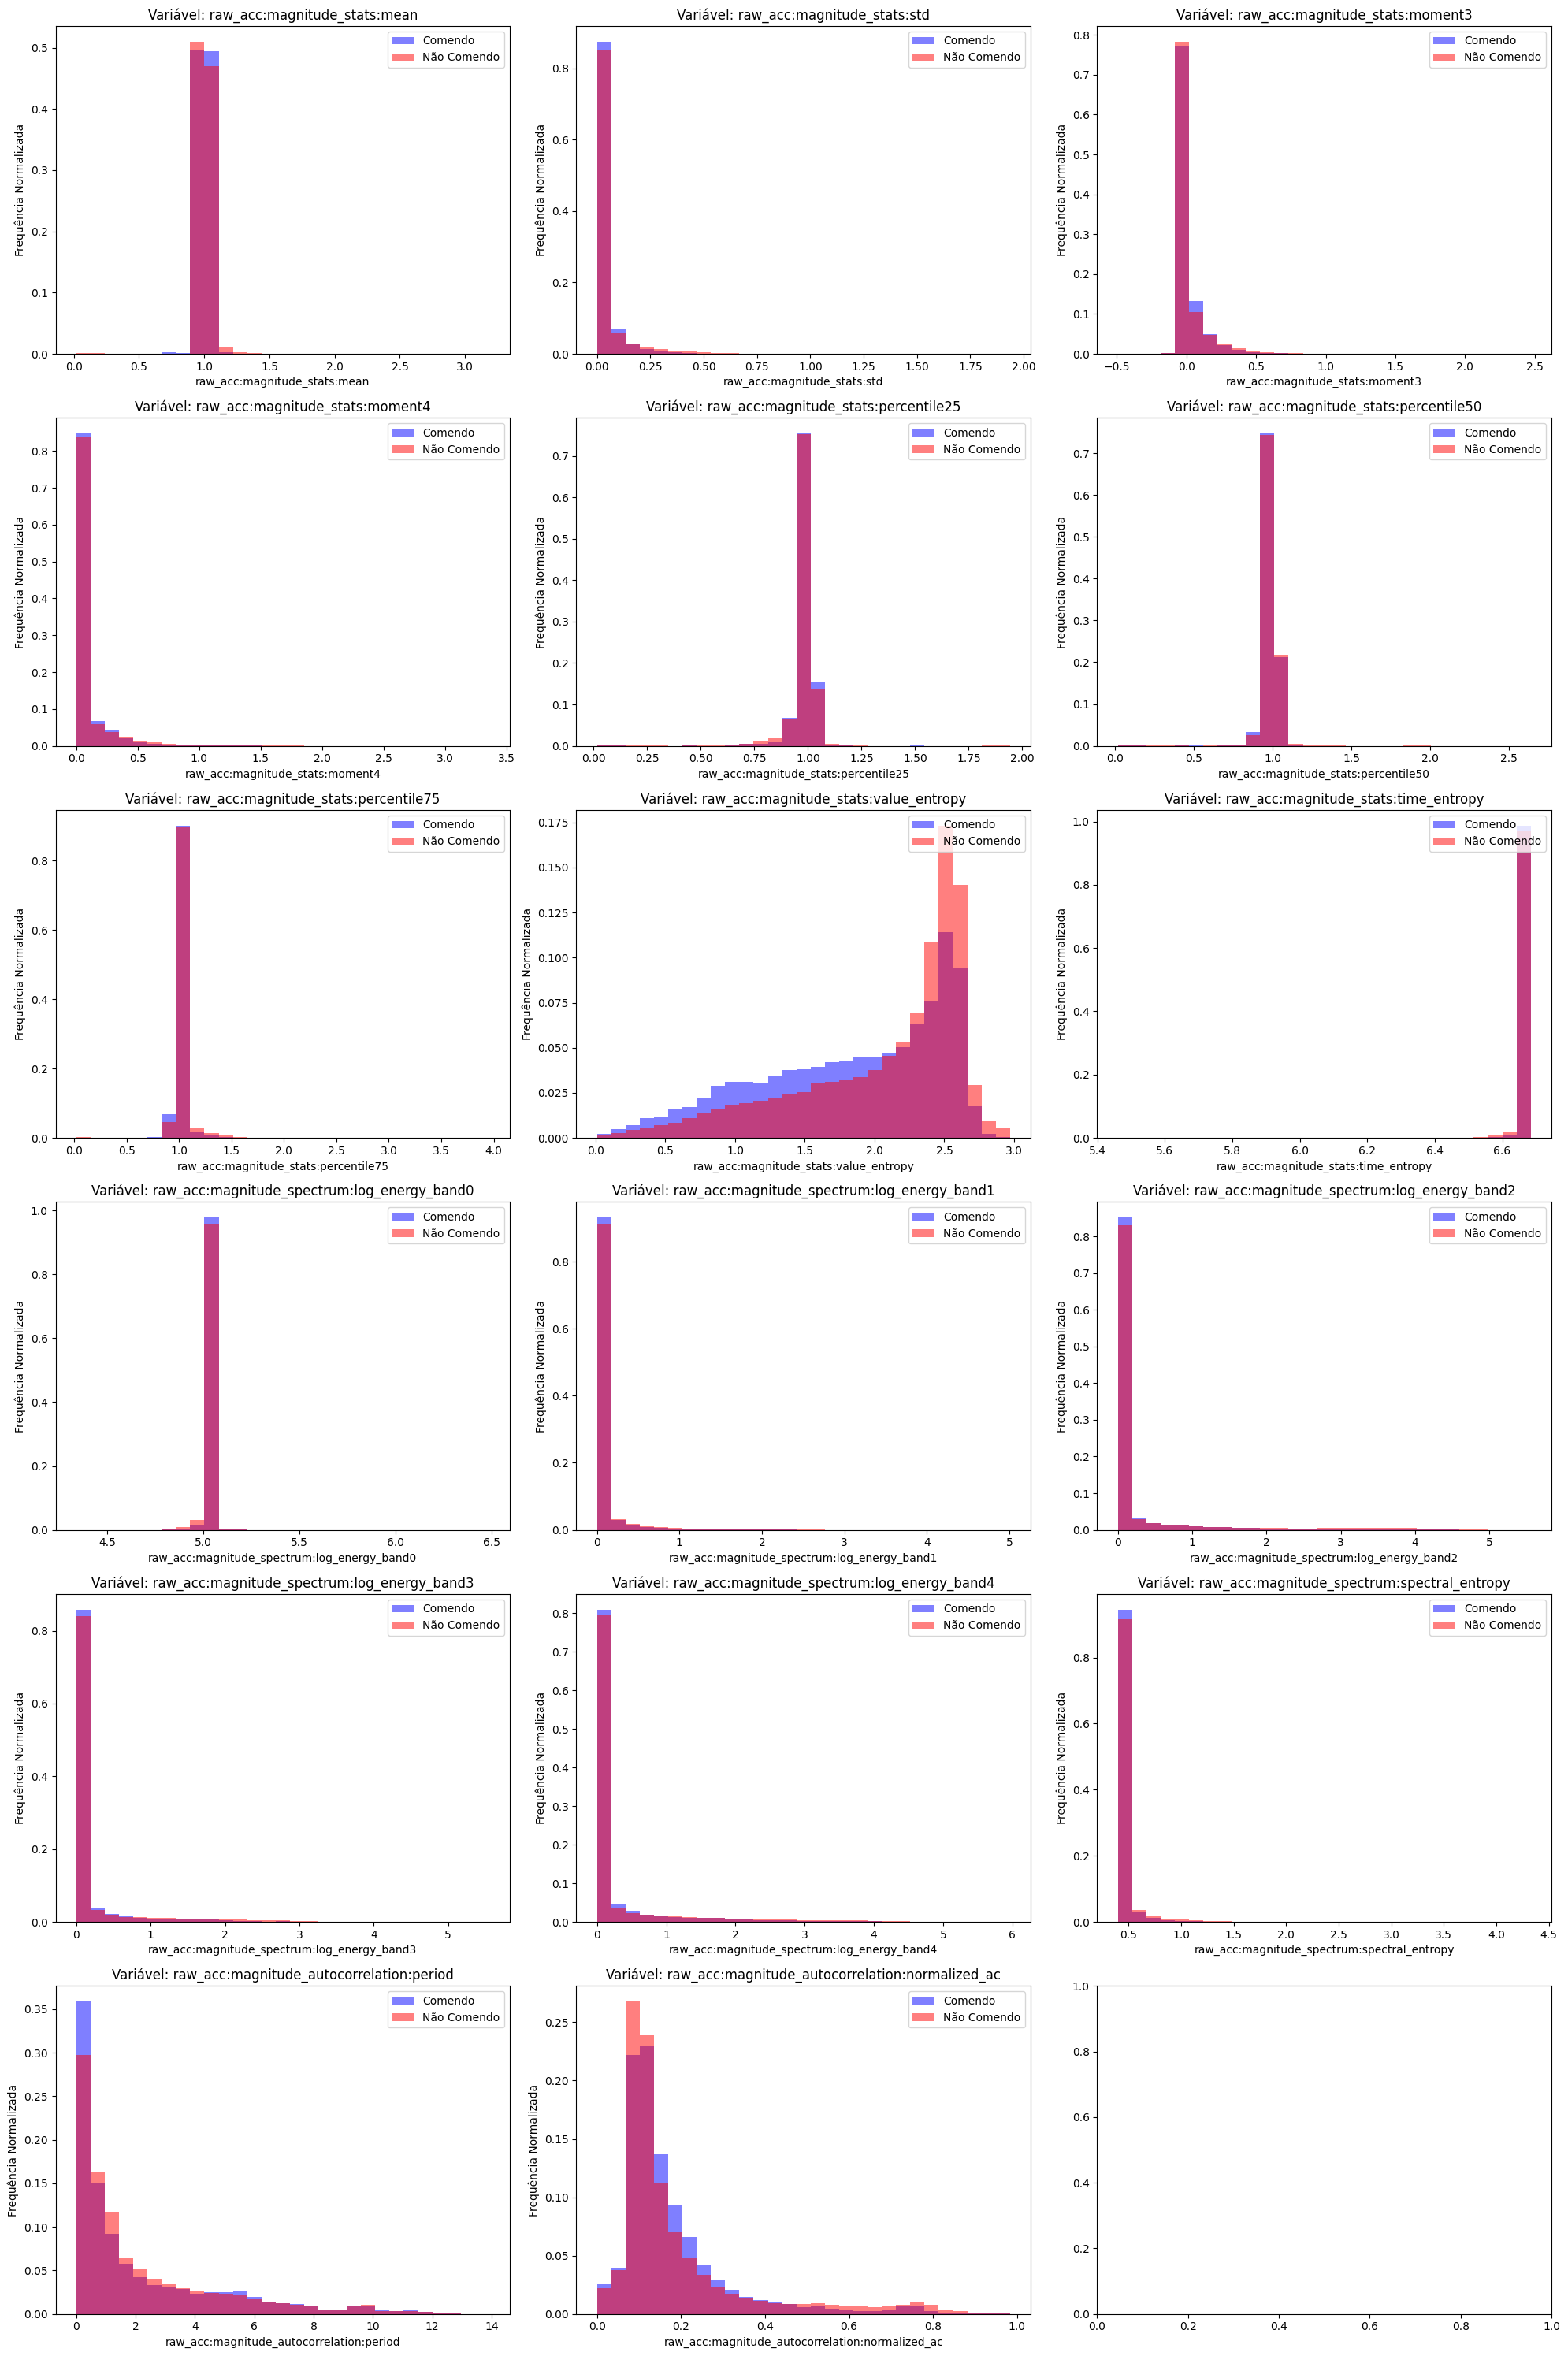

In [37]:
compara(1, n_graficos=17)#, matrix_min_max=[[5, 5.1], [-0.02, 0.2], [-0.02, 0.2], [-0.05, 0.2], [-0.02, 0.3], [0.43, 0.5]])

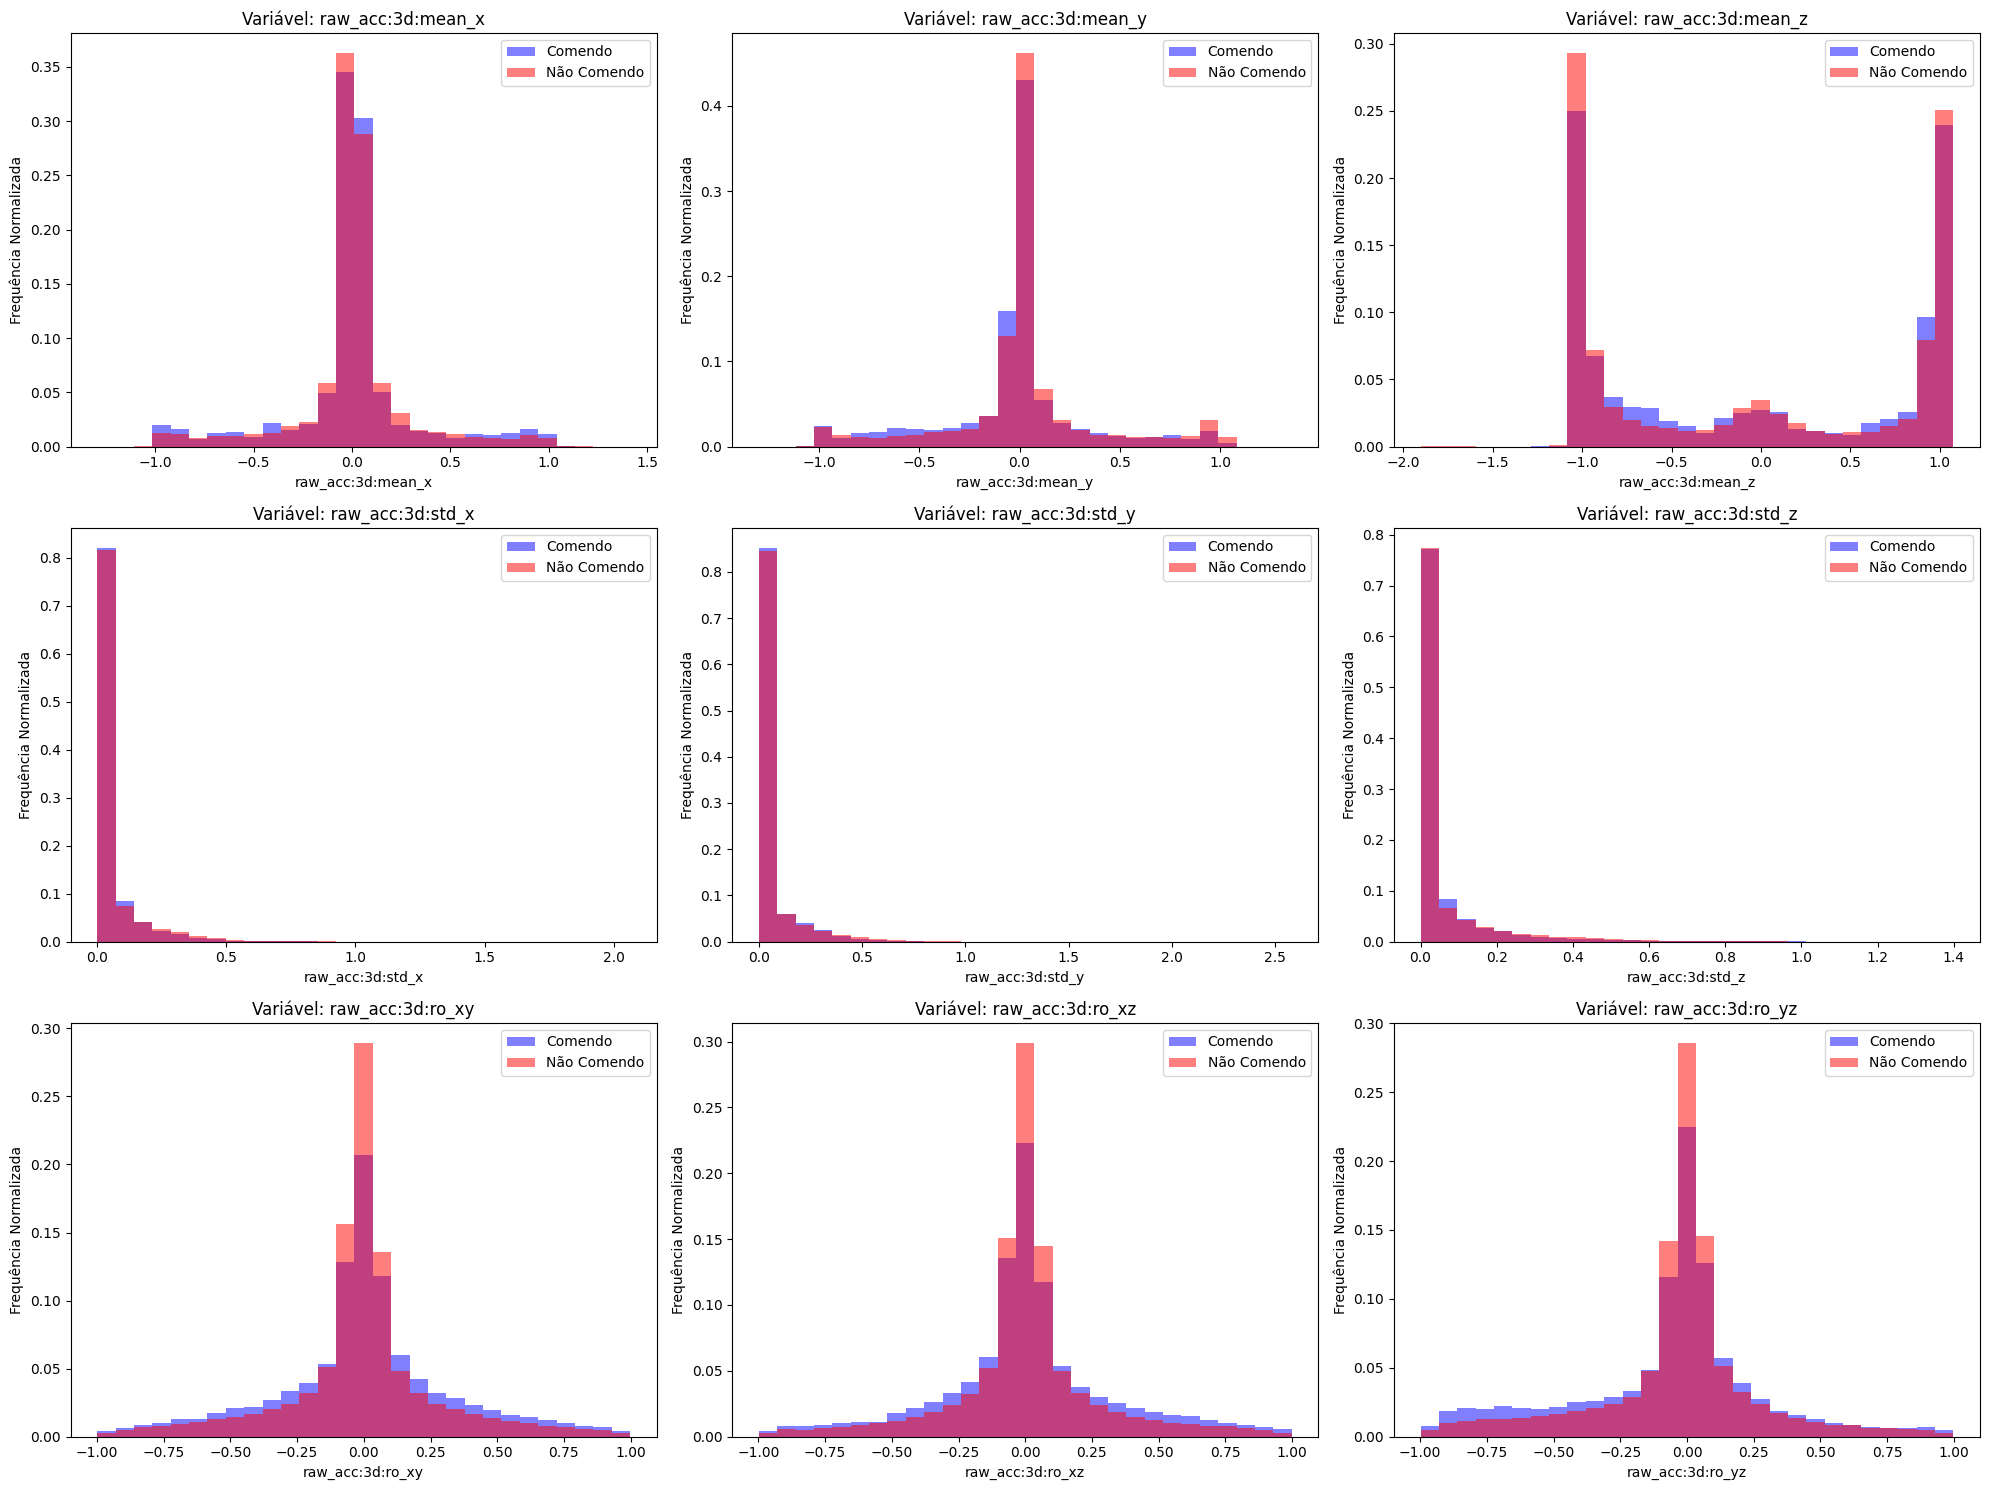

In [38]:
compara(column_names.index('raw_acc:3d:mean_x'), n_graficos=9)#, matrix_min_max=[[5, 5.1], [-0.02, 0.2], [-0.02, 0.2], [-0.05, 0.2], [-0.02, 0.3], [0.43, 0.5]])

In [39]:
# prompt: conte, separadamente para cada coluna do dataFrame df.test, quantos valores são nan
nan_counts = {}
for column in df_final.columns:
  nan_counts[column] = df_final[column].isna().sum()


In [40]:
# A pergunta é: Quais são os dados faltantes???  Kkkkkkk  - Quase Todos!!!!! :)))
nan_counts_0 = {}
nan_counts_1 = {}
nan_counts_2 = {}
print("Nome da Coluna  ( Não Comendo | Comendo | Não sabe )")
for column in df_final.columns:
  nan_counts_0[column] = df_final[df_final['label:EATING'] == 0][column].isna().sum()
  nan_counts_1[column] = df_final[df_final['label:EATING'] == 1][column].isna().sum()
  nan_counts_2[column] = df_final[df_final['label:EATING'].notna()][column].isna().sum()
  print(f"{column} ( {nan_counts_0[column]} | {nan_counts_1[column]} | {nan_counts_2[column]} )")

Nome da Coluna  ( Não Comendo | Comendo | Não sabe )
timestamp ( 0 | 0 | 0 )
raw_acc:magnitude_stats:mean ( 13 | 1 | 14 )
raw_acc:magnitude_stats:std ( 13 | 1 | 14 )
raw_acc:magnitude_stats:moment3 ( 13 | 1 | 14 )
raw_acc:magnitude_stats:moment4 ( 13 | 1 | 14 )
raw_acc:magnitude_stats:percentile25 ( 13 | 1 | 14 )
raw_acc:magnitude_stats:percentile50 ( 13 | 1 | 14 )
raw_acc:magnitude_stats:percentile75 ( 13 | 1 | 14 )
raw_acc:magnitude_stats:value_entropy ( 13 | 1 | 14 )
raw_acc:magnitude_stats:time_entropy ( 13 | 1 | 14 )
raw_acc:magnitude_spectrum:log_energy_band0 ( 13 | 1 | 14 )
raw_acc:magnitude_spectrum:log_energy_band1 ( 13 | 1 | 14 )
raw_acc:magnitude_spectrum:log_energy_band2 ( 13 | 1 | 14 )
raw_acc:magnitude_spectrum:log_energy_band3 ( 13 | 1 | 14 )
raw_acc:magnitude_spectrum:log_energy_band4 ( 13 | 1 | 14 )
raw_acc:magnitude_spectrum:spectral_entropy ( 13 | 1 | 14 )
raw_acc:magnitude_autocorrelation:period ( 13 | 1 | 14 )
raw_acc:magnitude_autocorrelation:normalized_ac ( 13 | 

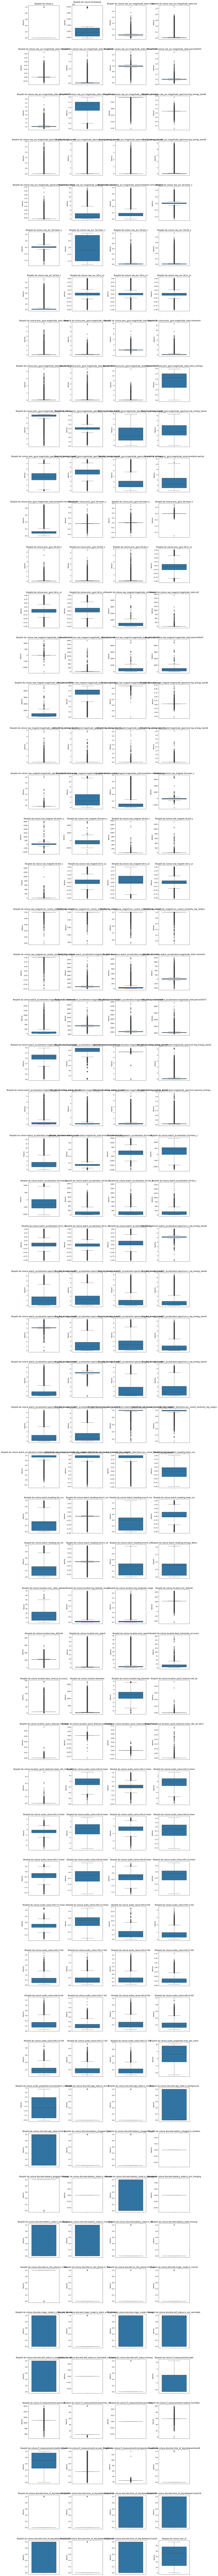

In [42]:
import seaborn as sns

def plot_boxplots(df, columns):
    num_columns = 4
    num_rows = math.ceil(len(columns) / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns*4, num_rows*4))
    fig.tight_layout(pad=5.0)

    for i, column in enumerate(columns):
        row = i // num_columns
        col = i % num_columns
        sns.boxplot(data=df[column], ax=axes[row, col])
        axes[row, col].set_title(f'Boxplot da coluna {column}')
        axes[row, col].set_ylabel('Valores')

    # Remove gráficos não utilizados
    for j in range(i+1, num_rows*num_columns):
        fig.delaxes(axes.flatten()[j])

    plt.show()

plot_boxplots(df_test, df_test.columns)

# PARTE 3: Preparando os dados

## 3.0) Transformado todos os dados em números
Os nomes de usuários são strings

In [4]:
# Transformando a coluna user_id para números
df_final['user_id'] = df_final['user_id'].astype('category').cat.codes

## 3.1) Imputação de dados faltantes

In [5]:
# SELEÇÃO DE O QUANTO VAI PREENCHER OS DADOS FALTANTES:
import ipywidgets as widgets
from IPython.display import display
mantem_NaN = False

def opcao1(b):
    global mantem_NaN
    print("Mantendo os NaN")
    mantem_NaN = True

def opcao2(b):
    global mantem_NaN
    print("Removendo os NaN")
    mantem_NaN = False

# Cria botões para cada opção
button1 = widgets.Button(description="Sim, mantenha NaN.")
button2 = widgets.Button(description="Não, retire NaN.")

# Associa as funções aos botões
button1.on_click(opcao1)
button2.on_click(opcao2)

# Cria uma caixa de layout para os botões
menu = widgets.VBox([widgets.Label("Seu Classificador pode trabalhar com NaN?"), button1, button2])

# Exibe o menu
display(menu)

Removendo os NaN


### 3.1.1) Preenchendo dados faltantes de 'label:EATING'

In [6]:
# tranformando todos os 'label:EATING' desconhecidos (NaN) que são muito improváveis de estarem comendo para 0
df_final.loc[
    (df_final['label:EATING'].isna()) & (
        (df_final['label:FIX_running'] == 1) |
        (df_final['label:BICYCLING'] == 1) |
        (df_final['label:OR_exercise'] == 1) |
        (df_final['label:BATHING_-_SHOWER'] == 1) |
        (df_final['label:WASHING_DISHES'] == 1) |
        (df_final['label:SINGING'] == 1) |
        (df_final['label:TOILET'] == 1) |
        (df_final['label:DRESSING'] == 1) |
        (df_final['label:AT_THE_GYM'] == 1) |
        (df_final['label:SLEEPING'] == 1)
    ), 'label:EATING'] = 0

### 3.1.2) Completando a tabela

In [7]:
# Primeiro precisamos tirar todos os NaN dos Labels, por que se não dá erro no próximo código:

# PADRONIZANDO OS LABELS PARA 0-NÃO 1-SIM 2-NÃO SABE
label_columns = df_final.filter(like='label:').columns                      # Selecionar colunas que começam com 'label:'
df_final[label_columns] = df_final[label_columns].fillna(2).astype('int')   # Substituir NaN por 2 nas colunas selecionadas


In [8]:
# AQUI COMPLETAMOS OS FALTANTES (NaN). VER EXPLICAÇÃO ABAIXO
if not mantem_NaN:
  # Identificar colunas que começam com 'label:'
  label_cols = [col for col in df_final.columns if col.startswith('label:')]

  # Agrupar por colunas 'label:' e calcular a mediana das outras colunas
  df_median = df_final.groupby(label_cols).transform('median')
  df_filled = df_median.apply(lambda col: col.fillna(col.median()), axis=0)  # O que ainda sobrou, faço a mediana da coluna toda.

  # Preencher valores NaN com as medianas correspondentes
  df_final = df_final.fillna(df_filled)

In [9]:
# Verificar quantos NaN sobraram em df_final
print(f'Quantidade de NaN em df_final: {df_final.isna().sum().sum()}')

Quantidade de NaN em df_final: 0


#### Explicação de como completamos os dados faltantes

A compleção dos dados NaN é um pouco complexa, por isso vou postar um exemplo abaixo.

Resumidamente: Fizemos a mediana dos valores apresentados pelos sensores agrupando eles pelos labels. Ou seja, se a pessoa estava comendo e assistindo televisão, os dados faltantes serão substituidos pela média apenas dos dados das pessoas que estavam comendo e vendo televisão.

Abaixo temos um código exemplo, em que o np.nan faltando em **'tamanho'** é será a média dos tamanhos apenas das caixas azuls que não são quadradas. E o np.nan faltando em **'custo'** será a média apenas das caixas que são azuls E quadradas.

No nosso projeto, sabemos que os dados não seguem um padrão característicos de normal, por isso optamos por fazer a mediana.

In [10]:
import pandas as pd
import numpy as np

# Dados de exemplo
data = [
    {"label:azul": 1.0, "label:quadrado": 0.0, "tamanho": 70, "custo": 5},
    {"label:azul": 1.0, "label:quadrado": 0.0, "tamanho": 20, "custo": 2},
    {"label:azul": 1.0, "label:quadrado": 0.0, "tamanho": np.nan, "custo": 3},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 50, "custo": np.nan},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 80, "custo": 9},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 30, "custo": 4},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 30, "custo": 8},
]

# Criar DataFrame
df = pd.DataFrame(data)

# Identificar colunas que começam com 'label:'
label_cols = [col for col in df.columns if col.startswith('label:')]

# Agrupar por colunas 'label:' e calcular a média das outras colunas
df_mean = df.groupby(label_cols).transform('mean')

# Preencher valores NaN com as médias correspondentes
df_filled = df.fillna(df_mean)

# Mostrar o resultado
print(df_filled)

   label:azul  label:quadrado  tamanho  custo
0         1.0             0.0     70.0    5.0
1         1.0             0.0     20.0    2.0
2         1.0             0.0     45.0    3.0
3         1.0             1.0     50.0    7.0
4         1.0             1.0     80.0    9.0
5         1.0             1.0     30.0    4.0
6         1.0             1.0     30.0    8.0


Mas ainda estou tendo problemas quando todos de um grupo são NaN.  
Nesse caso mantém os NaN no dataFrame. O que fazer?

In [11]:
import pandas as pd
import numpy as np

# Dados de exemplo
data = [
    {"label:azul": 1.0, "label:quadrado": 0.0, "tamanho": np.nan, "custo": 5},
    {"label:azul": 1.0, "label:quadrado": 0.0, "tamanho": np.nan, "custo": 2},
    {"label:azul": 1.0, "label:quadrado": 0.0, "tamanho": np.nan, "custo": 3},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 50, "custo": np.nan},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 80, "custo": 9},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 30, "custo": 4},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 30, "custo": 8},
]

# Criar DataFrame
df = pd.DataFrame(data)

# Identificar colunas que começam com 'label:'
label_cols = [col for col in df.columns if col.startswith('label:')]

# Agrupar por colunas 'label:' e calcular a média das outras colunas
df_mean = df.groupby(label_cols).transform('mean')

# Preencher valores NaN com as médias correspondentes
df_filled = df.fillna(df_mean)

# Mostrar o resultado
print(df_filled)


   label:azul  label:quadrado  tamanho  custo
0         1.0             0.0      NaN    5.0
1         1.0             0.0      NaN    2.0
2         1.0             0.0      NaN    3.0
3         1.0             1.0     50.0    7.0
4         1.0             1.0     80.0    9.0
5         1.0             1.0     30.0    4.0
6         1.0             1.0     30.0    8.0


A solução no momento é substituir esses valores ou por zero, ou pela média de toda a coluna, e não só das associações.

In [12]:
import pandas as pd
import numpy as np

# Dados de exemplo
data = [
    {"label:azul": 1.0, "label:quadrado": 0.0, "tamanho": np.nan, "custo": 5},
    {"label:azul": 1.0, "label:quadrado": 0.0, "tamanho": np.nan, "custo": 2},
    {"label:azul": 1.0, "label:quadrado": 0.0, "tamanho": np.nan, "custo": 3},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 50, "custo": np.nan},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 80, "custo": 9},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 30, "custo": 4},
    {"label:azul": 1.0, "label:quadrado": 1.0, "tamanho": 30, "custo": 8},
]

# Criar DataFrame
df = pd.DataFrame(data)

# Identificar colunas que começam com 'label:'
label_cols = [col for col in df.columns if col.startswith('label:')]

# Agrupar por colunas 'label:' e calcular a média das outras colunas
df_mean = df.groupby(label_cols).transform('mean')

# Preencher valores NaN com as médias correspondentes
df_filled = df.fillna(df_mean)
df_filled = df_filled.apply(lambda col: col.fillna(col.mean()), axis=0)

# Mostrar o resultado
print(df_filled)

   label:azul  label:quadrado  tamanho  custo
0         1.0             0.0     47.5    5.0
1         1.0             0.0     47.5    2.0
2         1.0             0.0     47.5    3.0
3         1.0             1.0     50.0    7.0
4         1.0             1.0     80.0    9.0
5         1.0             1.0     30.0    4.0
6         1.0             1.0     30.0    8.0


## 3.2) Configurando as classes (labels)

In [13]:
# Criando uma coluna chamada y, e atribuindo o valor de 'label:EATING' a ela.
df_final = df_final[df_final['label:EATING'] != 2]  # Apaga todas as linhas que desconhecemos o valor de Eating.
y_label = {0:'Nao Comendo', 1:'Comendo'}
df_final.insert(0, 'y', df_final['label:EATING'])

## 3.3) Apagando dados indesejados:

In [14]:
# Apagando dados indesejados de df_final:
df_final = df_final.drop(columns=[col for col in df_final.columns   # Apaga todas as colunas 'labels'
                                  if col.startswith('label:')])     # porque já copiamos os dados de 'label:EATING' para coluna 'y'
df_final = df_final.drop(columns=['label_source'])  # Apaga colunas que não interessam a gente.

# Mostrando a distribuição entre comendo e não comendo
print('Apagando dados indesejados de df_final... Ficou assim:')
print(f'comendo: {len(df_final[df_final.y == 1])}, não comendo: {len(df_final[df_final.y == 0])}, não conhecido: {len(df_final[df_final.y == 2])}')
print('percebemos que temos um desequilíbrio entre o número de \'Comendo\' e \'não comendo\'')

Apagando dados indesejados de df_final... Ficou assim:
comendo: 16594, não comendo: 283236, não conhecido: 0
percebemos que temos um desequilíbrio entre o número de 'Comendo' e 'não comendo'


## 3.4) Dividindo os dados

In [15]:
# DIVIDINDO O GRUPO DE TREINO E TESTE, PORÉM MANTENDO OS USUÁRIOS SEPARADOS.
gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df_final, groups=df_final['user_id']))   # Separa os índices de treinamento e teste
df_train = df_final.iloc[train_idx]   # Cria um novo DataFrame com os índices de treinamento
df_test = df_final.iloc[test_idx]     # Cria um novo DataFrame com os índices de teste
print(f"  Treinamento:\tShape = {df_train.shape}\n\t\tUsuarios: {len(df_train['user_id'].unique())}\n\tTeste:\tShape = {df_test.shape}\n\t\tUsuarios: {len(df_test['user_id'].unique())}")


  Treinamento:	Shape = (241983, 228)
		Usuarios: 48
	Teste:	Shape = (57847, 228)
		Usuarios: 12


## 3.4) Pré processamento final

In [16]:
# PRÉ PROCESSAMENTO FINAL.
X_train = df_train.drop(columns=['y'])
y_train = df_train['y']
X_test = df_test.drop(columns=['y'])
y_test = df_test['y']

In [17]:
# Normalizando os dados:
if not mantem_NaN:
  normalizer = Normalizer()
  X_train = normalizer.fit_transform(X_train)
  X_test = normalizer.transform(X_test)
else:
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

# PARTE 4: Treinando e avaliando modelos

## PARTE 4.0) Criando funções de apoio

In [18]:
# Avaliar o modelo
def avaliarModelo(modelo, X_test = X_test, y_test = y_test):
  y_pred = modelo.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Acurácia do modelo {type(modelo).__name__}: {accuracy:.2f}")

  print("\nRelatório de Classificação:")
  print(classification_report(y_test, y_pred, target_names=['Nao Comendo', 'Comendo']))

  print("Matriz de Confusão:")
  print(confusion_matrix(y_test, y_pred))

## PARTE 4.1) - SVM


SVM (Support Vector Machine) é um algoritmo de aprendizado supervisionado utilizado tanto para tarefas de classificação quanto de regressão. O objetivo principal do SVM é encontrar o hiperplano que melhor separa as classes em um espaço de características. Esse hiperplano é definido de tal maneira que a margem entre as classes é maximizada.

Vantagens do SVM

* **Eficaz em Altas Dimensionalidades:** SVM é eficaz em espaços de alta dimensionalidade e ainda funciona bem quando o número de dimensões é maior que o número de amostras.
* **Memória Eficiente:** Utiliza apenas um subconjunto de pontos de treinamento na função de decisão (os vetores de suporte), o que torna o modelo eficiente em termos de memória.
* **Flexibilidade com Funções de Kernel:** Permite a especificação de diferentes funções de kernel para ajustar a separação não linear dos dados.
Robustez: Pode ser ajustado para diferentes margens de erro utilizando um parâmetro regularizador, o que ajuda a lidar com casos de overfitting e underfitting.

Desvantagens do SVM

* **Complexidade Computacional:** O tempo de treinamento pode ser alto, especialmente para grandes conjuntos de dados.
* **Escolha do Kernel:** A escolha da função de kernel e seus parâmetros pode ser complexa e requer experimentação e validação cruzada.
* **Escalabilidade:** SVM não é muito eficiente quando o número de amostras é muito grande devido à complexidade computacional do algoritmo.
Interpretabilidade: Os modelos SVM podem ser difíceis de interpretar, especialmente quando usam kernels complexos.

In [ ]:
from sklearn.svm import SVC

In [ ]:
# KERNEL LINEAR
modelo = SVC(kernel='linear', class_weight='balanced', random_state=42)
modelo.fit(X_train, y_train)
avaliarModelo(modelo, X_test, y_test)

Acurácia do modelo SVC: 0.06

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.00      0.00      0.00     54222
     Comendo       0.06      1.00      0.12      3625

    accuracy                           0.06     57847
   macro avg       0.03      0.50      0.06     57847
weighted avg       0.00      0.06      0.01     57847

Matriz de Confusão:
[[    0 54222]
 [    0  3625]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# KERNEL POLY 3o GRAU
modelo = SVC(kernel='poly', class_weight='balanced', degree=3, random_state=42)
modelo.fit(X_train, y_train)
avaliarModelo(modelo, X_test, y_test)

In [ ]:
# KERNEL SIGMOID
modelo = SVC(kernel='sigmoid', class_weight='balanced', degree=3, random_state=42)
modelo.fit(X_train, y_train)
avaliarModelo(modelo, X_test, y_test)

Acurácia do modelo SVC: 0.06

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.00      0.00      0.00     54222
     Comendo       0.06      1.00      0.12      3625

    accuracy                           0.06     57847
   macro avg       0.03      0.50      0.06     57847
weighted avg       0.00      0.06      0.01     57847

Matriz de Confusão:
[[    0 54222]
 [    0  3625]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# KERNEL RBF
modelo = SVC(kernel='rbf', class_weight='balanced', degree=3, random_state=42)
modelo.fit(X_train, y_train)
avaliarModelo(modelo, X_test, y_test)

Acurácia do modelo SVC: 0.06

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.00      0.00      0.00     54222
     Comendo       0.06      1.00      0.12      3625

    accuracy                           0.06     57847
   macro avg       0.03      0.50      0.06     57847
weighted avg       0.00      0.06      0.01     57847

Matriz de Confusão:
[[    0 54222]
 [    0  3625]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# KERNEL RBF COM GAMA ESPECIFICO
modelo = SVC(kernel='rbf', gamma='scale', class_weight='balanced', degree=3, random_state=42)
modelo.fit(X_train, y_train)
avaliarModelo(modelo, X_test, y_test)

## PARTE 4.2) Gradient Boosting

### PARTE 4.2.1) Aumento de Gradiente do Histograma (Histogram Gradient Boosting)


Histogram Gradient Boosting é uma variação do algoritmo de Gradient Boosting que utiliza histogramas para acelerar o processo de treinamento. Em vez de calcular os ganhos de divisão exatos para cada ponto de dados, o Histogram Gradient Boosting agrupa os valores das características em bins (intervalos), criando histogramas. Isso reduz a complexidade computacional e a quantidade de memória necessária, tornando o algoritmo mais eficiente, especialmente em conjuntos de dados grandes.

Vantagens:
* **Desempenho Rápido:** A utilização de histogramas acelera consideravelmente o treinamento em grandes conjuntos de dados.
* **Escalabilidade:** Projetado para ser eficiente em grandes conjuntos de dados, tanto em termos de tempo quanto de memória.
* **Suporte para Dados Categóricos:** Pode lidar diretamente com características categóricas sem a necessidade de codificação one-hot.
* **Memória Eficiente:** Requer menos memória em comparação com outros métodos de Gradient Boosting.
* **Dados NaN:** Trabalha nativamente com dados faltantes (NaN), sem necessidade de excluir ou estimar estes dados.

Desvantagens:
* **Complexidade de Implementação:** A implementação pode ser mais complexa devido ao binning e ao cálculo de ganhos de divisão com histogramas.
* **Escolha de Parâmetros:** Requer ajuste cuidadoso dos hiperparâmetros, como o número de bins, que pode afetar significativamente o desempenho.
* **Interpretação:** Como outros modelos de boosting, pode ser difícil de interpretar e entender os resultados em termos de variáveis individuais.

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
print('Quantidade de comendo:', df_train[df_train['y'] == 1].shape[0])
print('Quantidade de não comendo:', df_train[df_train['y'] == 0].shape[0])

Quantidade de comendo: 12969
Quantidade de não comendo: 229014


#### 4.2.1.1) **HistGradientBoosting** com os parâmetros ***default***

In [ ]:
# Criar o modelo HistGradientBoostingClassifier

y = df_final['y']
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
hgbc = HistGradientBoostingClassifier(class_weight=class_weight_dict , random_state=42)

# Treinar o modelo
hgbc.fit(X_train, y_train)


HistGradientBoostingClassifier(class_weight={0: 0.5292935926224067,
                                             1: 9.034289502229722},
                               random_state=42)

In [ ]:
# Avaliar o modelo com os dados de TESTE (nunca vistos)
avaliarModelo(hgbc)

Acurácia do modelo HistGradientBoostingClassifier: 0.85

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.95      0.89      0.92     54222
     Comendo       0.14      0.27      0.18      3625

    accuracy                           0.85     57847
   macro avg       0.54      0.58      0.55     57847
weighted avg       0.90      0.85      0.87     57847

Matriz de Confusão:
[[48149  6073]
 [ 2646   979]]


Vemos que o modelo, nos parâmetros não ajustados teve um desempenho muito ruim, com uma precisão de apenas 14%.

Ou seja, em números absolutos, observando a matriz de confusão vemos que das 6593 vezes que o modelo "achou" que o usuário estava comendo ele só acertou 979 (14%), errando 6073 vezes (muito mais).

#### 4.2.1.2) **HistGradientBoosting** com os parâmetros ***personalizados***

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
# Configurando hiperparâmetros
params = {
    'learning_rate': 0.1,
    'max_iter': 100,
    'max_leaf_nodes': 31,
    'max_depth': 3,
    'min_samples_leaf': 20,
    'l2_regularization': 1.0,
    'max_bins': 255,
    'early_stopping': True,
    'scoring': 'loss',
    'validation_fraction': 0.1,
    'n_iter_no_change': 10,
    'tol': 1e-7,
    'verbose': 0,
    'random_state': 42
}

In [ ]:
# Instanciando o modelo com os hiperparâmetros configurados
hgbc = HistGradientBoostingClassifier(**params)

# Treinando o modelo
hgbc.fit(X_train, y_train)

HistGradientBoostingClassifier(class_weight='balanced', early_stopping=True,
                               l2_regularization=1.0, max_depth=3,
                               random_state=42)

In [ ]:
# Avaliar o modelo com os dados de TESTE (nunca vistos)
avaliarModelo(hgbc)

Acurácia do modelo HistGradientBoostingClassifier: 0.73

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.96      0.74      0.84     54222
     Comendo       0.13      0.56      0.21      3625

    accuracy                           0.73     57847
   macro avg       0.54      0.65      0.52     57847
weighted avg       0.91      0.73      0.80     57847

Matriz de Confusão:
[[40271 13951]
 [ 1600  2025]]


In [ ]:
# Avaliar o modelo com os dados de TREINAMENTO (avaliação de overfitting)
avaliarModelo(hgbc, X_train, y_train)

Acurácia do modelo HistGradientBoostingClassifier: 0.77

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.99      0.76      0.86    229014
     Comendo       0.18      0.91      0.29     12969

    accuracy                           0.77    241983
   macro avg       0.58      0.83      0.58    241983
weighted avg       0.95      0.77      0.83    241983

Matriz de Confusão:
[[173472  55542]
 [  1149  11820]]


In [ ]:
from imblearn.over_sampling import SMOTE

# Aplicando SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print('ANTES DO SMOTE:')
print('Quantidade de comendo:', y_train.value_counts()[1])
print('Quantidade de não comendo:', y_train.value_counts()[0])
print('APÓS SMOTE:')
print('Quantidade de comendo:', y_train_resampled.value_counts()[1])
print('Quantidade de não comendo:', y_train_resampled.value_counts()[0])

ANTES DO SMOTE:
Quantidade de comendo: 12969
Quantidade de não comendo: 229014
APÓS SMOTE:
Quantidade de comendo: 229014
Quantidade de não comendo: 229014


In [ ]:
# Instanciando o modelo novamente para resetar o treinamento prévio
hgbc = HistGradientBoostingClassifier(**params)

# Treinando o modelo com os dados balanceados
hgbc.fit(X_train_resampled, y_train_resampled)

HistGradientBoostingClassifier(early_stopping=True, l2_regularization=1.0,
                               max_depth=3, random_state=42)

In [ ]:
# Avaliar o modelo com os dados de TESTE (nunca vistos)
avaliarModelo(hgbc)

Acurácia do modelo HistGradientBoostingClassifier: 0.81

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.95      0.84      0.89     54222
     Comendo       0.15      0.40      0.22      3625

    accuracy                           0.81     57847
   macro avg       0.55      0.62      0.56     57847
weighted avg       0.90      0.81      0.85     57847

Matriz de Confusão:
[[45664  8558]
 [ 2157  1468]]


In [ ]:
# Avaliar o modelo com os dados de TREINAMENTO (avaliação de overfitting)
avaliarModelo(hgbc, X_train_resampled, y_train_resampled)

Acurácia do modelo HistGradientBoostingClassifier: 0.89

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.91      0.86      0.88    229014
     Comendo       0.87      0.92      0.89    229014

    accuracy                           0.89    458028
   macro avg       0.89      0.89      0.89    458028
weighted avg       0.89      0.89      0.89    458028

Matriz de Confusão:
[[196454  32560]
 [ 18618 210396]]


In [ ]:
# Ainda está errando muito o comendo, vamos ajustar o peso das classes:
class_weight = {0: 1, 1: 2}

In [ ]:
# re-instanciando o modelo para apagar o treinamento anterio e colocar o peso das classes ajustados
hgbc = HistGradientBoostingClassifier(**params, class_weight=class_weight)
hgbc.fit(X_train_resampled, y_train_resampled)

HistGradientBoostingClassifier(class_weight={0: 1, 1: 2}, early_stopping=True,
                               l2_regularization=1.0, max_depth=3,
                               random_state=42)

In [ ]:
# Avaliar o modelo com os dados de TESTE (nunca vistos)
avaliarModelo(hgbc)

Acurácia do modelo HistGradientBoostingClassifier: 0.68

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.97      0.68      0.80     54222
     Comendo       0.13      0.70      0.21      3625

    accuracy                           0.68     57847
   macro avg       0.55      0.69      0.51     57847
weighted avg       0.92      0.68      0.76     57847

Matriz de Confusão:
[[36705 17517]
 [ 1095  2530]]


Piorou ainda mais...  Aff!!!

### PARTE 4.2.2) XGBoost

XGBoost (Extreme Gradient Boosting) é uma biblioteca de aprendizado de máquina otimizada para desempenho e eficiência. É amplamente utilizada para problemas de classificação e regressão devido à sua capacidade de manejar grandes conjuntos de dados e sua eficácia em competições de ciência de dados.

***Vantagens do XGBoost:***
* **Performance:** Implementação altamente eficiente que utiliza otimizações de hardware, paralelização e uso eficiente de memória.
* **Regularização:** Possui parâmetros de regularização incorporados (L1 e L2) que ajudam a prevenir overfitting.
* **Flexibilidade:** Suporta uma variedade de funções de perda e é personalizável para diferentes tipos de problemas.
* **Manejo de Dados Faltantes:** Lida eficientemente com dados faltantes durante o treinamento.
* **Tuning de Hiperparâmetros:** Oferece uma ampla gama de hiperparâmetros que podem ser ajustados para otimizar o desempenho do modelo.
* **Bibliotecas e Interfaces:** Compatível com várias linguagens de programação, incluindo Python, R, Julia e Java.

***Desvantagens do XGBoost:***
* **Complexidade de Implementação:** Pode ser mais complexo de configurar e ajustar em comparação com modelos mais simples.
* **Tempo de Treinamento:** Para conjuntos de dados muito grandes ou com muitos hiperparâmetros para ajustar, o tempo de treinamento pode ser significativo.
* **Recursos Computacionais:** Pode exigir bastante memória e poder computacional, especialmente para grandes conjuntos de dados.
* **Interpretação:** Menos interpretável do que modelos lineares simples, o que pode ser uma desvantagem em contextos onde a explicabilidade é crucial.

#### Treinando com dados sem NaN

In [ ]:
import xgboost as xgb

# Calcular scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Criar e treinar o modelo
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, learning_rate=0.01, max_depth=10, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
avaliarModelo(model, X_train, y_train)

Acurácia do modelo XGBClassifier: 0.90

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       1.00      0.90      0.94    229014
     Comendo       0.35      0.99      0.52     12969

    accuracy                           0.90    241983
   macro avg       0.67      0.94      0.73    241983
weighted avg       0.96      0.90      0.92    241983

Matriz de Confusão:
[[205141  23873]
 [   131  12838]]


In [ ]:
avaliarModelo(model)

Acurácia do modelo XGBClassifier: 0.81

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.95      0.83      0.89     54222
     Comendo       0.13      0.38      0.20      3625

    accuracy                           0.81     57847
   macro avg       0.54      0.61      0.54     57847
weighted avg       0.90      0.81      0.85     57847

Matriz de Confusão:
[[45226  8996]
 [ 2238  1387]]


#### Treinado NaN incluidos nos dados de entrada (o modelo aceita)

In [ ]:
# Calcular scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Criar e treinar o modelo
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
avaliarModelo(model)

Acurácia do modelo XGBClassifier: 0.79

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.95      0.82      0.88     54222
     Comendo       0.13      0.40      0.19      3625

    accuracy                           0.79     57847
   macro avg       0.54      0.61      0.54     57847
weighted avg       0.90      0.79      0.84     57847

Matriz de Confusão:
[[44265  9957]
 [ 2175  1450]]


## PARTE 4.3) Militino

Segunda Atualização

##PARTE 4.4) CNN (Redes Neurais Convolucionais)

*   Tipo especializado de rede neural projetado para processar dados com uma estrutura de grade.​
*   Majoritariamente usada para classificação de imagens, mas também pode ser usada para séries temporais.
*   Usam princípios de álgebra linear (como multiplicação de matrizes) para encontrar padrões ocultos
*   Eficazes em identificar padrões locais e hierárquicos nos dados.​

Para esse trabalho:​

* Aplicada para classificação binária;​
* Aprendizado supervisionado.​

**Vantagens:​**

*  Eficientes na extração de características relevantes das entradas;​
*  Camadas de convolução reduzem a necessidade de muitos parâmetros em comparação com redes totalmente conectadas;​
*  Autoaprendizagem.

**Desvantagens:​**

*  Necessidade de grandes conjuntos de dados​
*  Tendência ao overfitting sem técnicas adequadas de regularização.​
*  “Caixa-Preta”: não sabe como e por que sua rede neural chega a um determinado resultado

**Estrutura do modelo**

*   Camadas convolucionais: detectam padrões temporais.​
*   Camadas de Pooling: reduzem a dimensionalidade, mantendo o que é importante.
*   Camada Densa: realiza a classificação final.​

In [19]:
import tensorflow as tf
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Define the CNN model
model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
7562/7562 [==============================] - 177s 23ms/step - loss: 0.2114 - binary_accuracy: 0.9464 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2541 - val_binary_accuracy: 0.9373 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
7562/7562 [==============================] - 145s 19ms/step - loss: 0.2100 - binary_accuracy: 0.9464 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2349 - val_binary_accuracy: 0.9373 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
7562/7562 [==============================] - 140s 19ms/step - loss: 0.2097 - binary_accuracy: 0.9464 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2346 - val_binary_accuracy: 0.9373 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
7562/7562 [==============================] - 218s 29ms/step - loss: 0.2097 - binary_accuracy: 0.9464 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2375 - val_binary_accuracy: 0.9373 - val_precision: 

1808/1808 [==============================] - 17s 9ms/step
Acurácia do modelo Sequential: 0.94

Relatório de Classificação:
              precision    recall  f1-score   support

 Nao Comendo       0.94      1.00      0.97     54222
     Comendo       0.00      0.00      0.00      3625

    accuracy                           0.94     57847
   macro avg       0.47      0.50      0.48     57847
weighted avg       0.88      0.94      0.91     57847



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


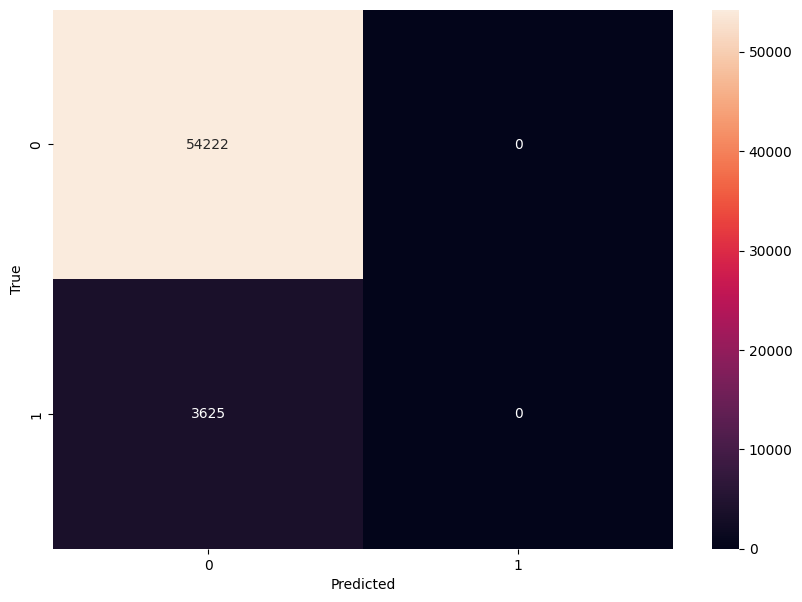

In [21]:
from sklearn.metrics import accuracy_score
import seaborn as sns

def avaliar(modelo, X_test=X_test, y_test=y_test):
    y_pred = modelo.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  # Converter probabilidades para classes binárias

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia do modelo {type(modelo).__name__}: {accuracy:.2f}")

    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Nao Comendo', 'Comendo']))

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Avaliar o modelo usando a função criada
avaliar(model, X_test, y_test)